In [1]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('train.csv')
other = pd.read_csv('unique_m.csv').drop(['critical_temp','material'],axis=1)
df = pd.concat([df1,other],axis=1)
original_columns = len(df.columns)
print(df.shape)
df.head()

(21263, 168)


,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [30]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge,LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
cols = df.columns
# Create a new DataFrame with just the markdown
df2 = pd.DataFrame([['---',]*len(cols)], columns=cols)
#Create a new concatenated DataFrame
df3 = pd.concat([df2, df.head()])
#Save as markdown
df3.to_csv("raw_data.md", sep="|", index=False)

In [4]:
# remove all columns that have a very small variance
threshold=0.05
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=threshold).fit(df)
df = pd.DataFrame(selector.transform(df),columns=df.columns[selector.get_support()])
df.shape


(21263, 132)

In [5]:
#drop any duplicate features
df = df.transpose().drop_duplicates(keep='first').transpose()
print(df.shape)

(21263, 132)


In [6]:
#Now drop any correlated features
correlation_matrix = df.corr() 
mutually_correlated_features = set()  
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            if colname!='critical_temp':
                mutually_correlated_features.add(colname)
print(len(mutually_correlated_features))
df.drop(mutually_correlated_features,axis=1,inplace=True)
df.shape

55


(21263, 77)

In [7]:
#This gets rid of features that have a absolute correlation with the target less than 0.1

correlation_threshhold = 0.1

corr = pd.DataFrame(df.corr()['critical_temp'])
corr['abs'] = np.abs(corr['critical_temp'])
corr = corr.sort_values(by='abs',ascending=False).drop('abs',axis=1).dropna().reset_index()
corr = corr.rename(columns={'index':'feature','critical_temp':'corr'}).loc[1:]

low_correlated_features = list(corr[np.abs(corr['corr'])<=correlation_threshhold]['feature'])
df.drop(low_correlated_features,axis=1,inplace=True)
df.shape

(21263, 36)

In [8]:
print(str(original_columns-df.shape[1])+' features were found to be irrelevant')

132 features were found to be irrelevant


In [9]:
df.to_csv('data_filtered.csv')

In [10]:
df.shape

(21263, 36)

In [11]:
cols = df.columns
# Create a new DataFrame with just the markdown
df2 = pd.DataFrame([['---',]*len(cols)], columns=cols)
#Create a new concatenated DataFrame
df3 = pd.concat([df2, df.head()])
#Save as markdown
df3.to_csv("cleaned_data.md", sep="|", index=False)

In [12]:
df = pd.read_csv('data_filtered.csv')
X = df.drop('critical_temp',axis=1)
y = df['critical_temp']

corr = pd.DataFrame(df.corr()['critical_temp'])
corr['abs'] = np.abs(corr['critical_temp'])
corr = corr.sort_values(by='abs',ascending=False).drop('abs',axis=1).dropna().reset_index()
corr = corr.rename(columns={'index':'feature'}).loc[1:]

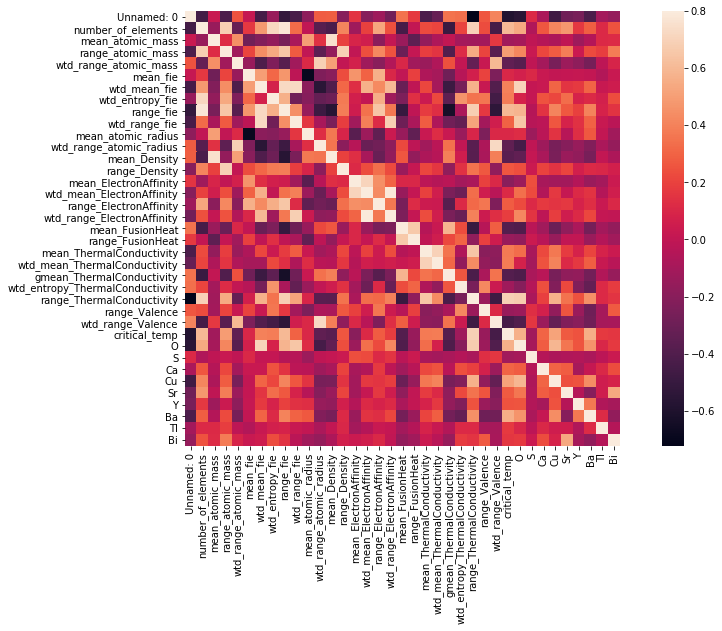

In [13]:
plt.figure(figsize=(15,8))
corrmat = df.corr()
sns.heatmap(corrmat, vmax=.8, square=True);

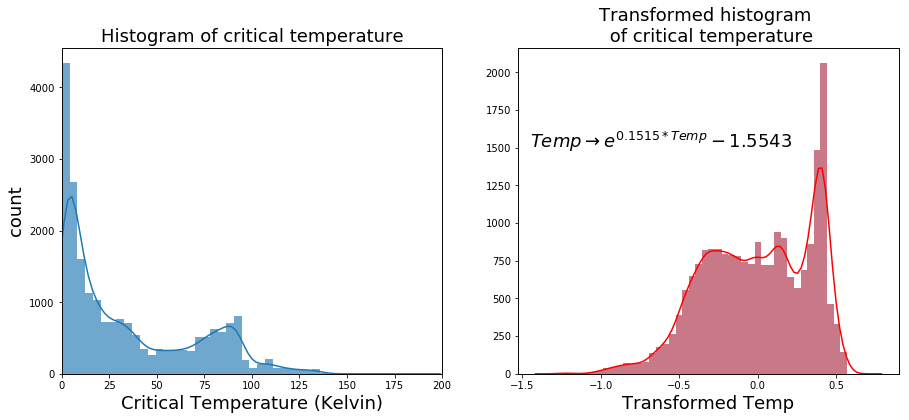

In [31]:
df = pd.read_csv('data_filtered.csv').drop('Unnamed: 0',axis=1)
y = df['critical_temp']
e=0.1515151515151516
y_mean = y.apply(lambda x: (x**e)).mean()
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('Histogram of critical temperature',fontsize=18)
ax1 = sns.distplot(y, kde=False)
# Creating another Y axis
second_ax1 = ax1.twinx()
#Plotting kde without hist on the second Y axis
sns.distplot(y, ax=second_ax1, kde=True, hist=True)
#Removing Y ticks from the second axis
second_ax1.set_yticks([])
ax1.set_ylabel('count',fontsize=18)
ax1.set_xlabel('Critical Temperature (Kelvin)',fontsize=18)
plt.xlim(0,200)

plt.subplot(1,2,2)
plt.title('Transformed histogram \n of critical temperature',fontsize=18)
transform_text = r'$Temp\rightarrow e^{0.1515*Temp}-1.5543$'
transformed = y.apply(lambda x: (x**e)-y_mean)
ax2 = sns.distplot(transformed, kde=False)
# Creating another Y axis
second_ax2 = ax2.twinx()
#Plotting kde without hist on the second Y axis
sns.distplot(transformed, ax=second_ax2, kde=True, hist=True,color='red')
#Removing Y ticks from the second axis
second_ax2.set_yticks([])
ax2.text(-1.45,1500,transform_text,fontsize=18)
ax2.set_xlabel('Transformed Temp',fontsize=18)
plt.subplots_adjust(wspace=0.2)
plt.show()

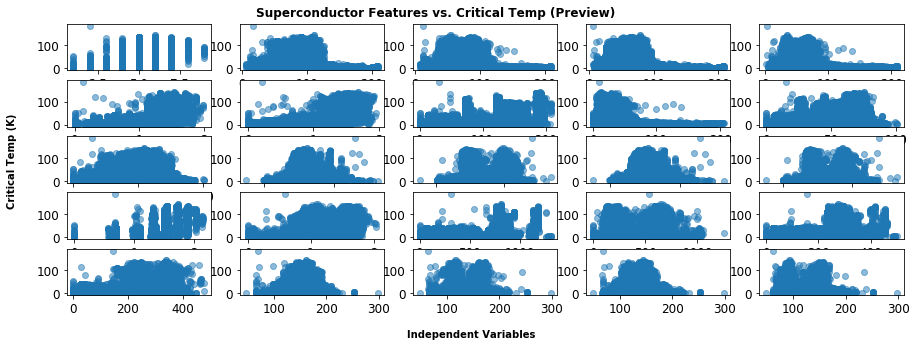

<Figure size 432x288 with 0 Axes>

In [85]:
#Preview of scatter plots between the dependent variable, 'critical temp', and the independent variables of 'feature_data'.
feature_data = pd.read_csv('train.csv')
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,5))
fig.text(0.3, 0.9, 'Superconductor Features vs. Critical Temp (Preview)', fontsize='large', weight='bold')
fig.text(0.5, 0.01, 'Independent Variables', ha='center', fontsize='medium', weight='bold')
fig.text(0.07, 0.5, 'Critical Temp (K)', va='center', rotation='vertical', fontsize='medium', weight='bold')
for i, ax in enumerate(axes.flatten()):
    ax.scatter(feature_data.iloc[:,i], feature_data.iloc[:,81], alpha=0.5)
    ax.tick_params(axis='both',labelsize=12)

plt.show()
plt.tight_layout()

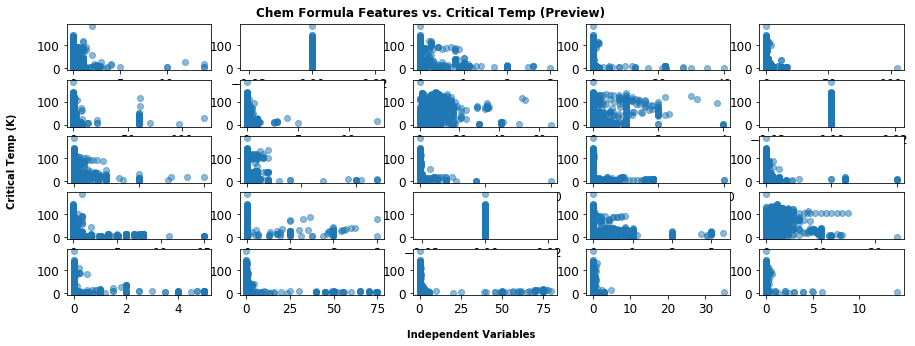

In [86]:
# Preview of scatter plots between the dependent variable, 'critical temp', and the independent variables of 'sc_chem_formula'.
sc_chem_formula = pd.read_csv('unique_m.csv')
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,5))
fig.text(0.3, 0.9, 'Chem Formula Features vs. Critical Temp (Preview)', fontsize='large', weight='bold')
fig.text(0.5, 0.01, 'Independent Variables', ha='center', fontsize='medium', weight='bold')
fig.text(0.07, 0.5, 'Critical Temp (K)', va='center', rotation='vertical', fontsize='medium', weight='bold')
for i, ax in enumerate(axes.flatten()):
    ax.scatter(sc_chem_formula.iloc[:,i], sc_chem_formula.iloc[:,86], alpha=0.5)
    ax.tick_params(axis='both',labelsize=12)

plt.show()

In [67]:
e=0.1515151515151516
intercept = 1.5542
y_t = y.apply(lambda x: (x**e)-intercept)
X_train, X_test, y_train, y_test = train_test_split(X, y_t, test_size=0.3, random_state=42)

In [56]:
uni_reg = LinearRegression()
uni_reg.fit(X_train, y_train)
y_pred = uni_reg.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 : ',r2_score(y_test, y_pred))

Mean Absolute Error: 0.14069404576805655
Mean Squared Error: 0.03388799410648372
Root Mean Squared Error: 0.1840869199766342
R2 :  0.7028640541493161


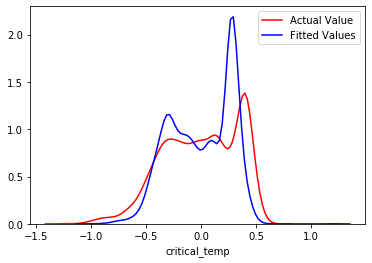

In [57]:
%matplotlib inline 
import seaborn as sns
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1);

In [114]:
from sklearn import  preprocessing
from sklearn.model_selection import KFold
X_scaled = preprocessing.MinMaxScaler()
X = X_scaled.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y_t, test_size=0.3, random_state=42)

In [115]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)
accuracy_res = []
prediction_df = []
count=1
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test, y_train, y_test = train_test_split(X, y_t, test_size=0.3, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    accuracy = model.score(X_test,y_test)
    accuracy_res.append(accuracy)    
    prediction_df.append(predictions.tolist())    
    print (count)
    count +=1

TRAIN: [ 4253  4254  4255 ... 21260 21261 21262] TEST: [   0    1    2 ... 4250 4251 4252]
1
TRAIN: [    0     1     2 ... 21260 21261 21262] TEST: [4253 4254 4255 ... 8503 8504 8505]
2
TRAIN: [    0     1     2 ... 21260 21261 21262] TEST: [ 8506  8507  8508 ... 12756 12757 12758]
3
TRAIN: [    0     1     2 ... 21260 21261 21262] TEST: [12759 12760 12761 ... 17008 17009 17010]
4
TRAIN: [    0     1     2 ... 17008 17009 17010] TEST: [17011 17012 17013 ... 21260 21261 21262]
5


In [ ]:
#Linear Regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
accuracy is:  70.28640541493175 %


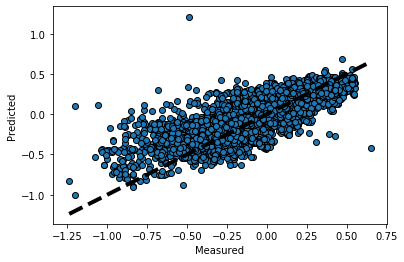

In [78]:
model = LinearRegression()
model.fit(X_train,y_train)
print (model)

predictions = model.predict(X_test)
accuracy = model.score(X_test,y_test)

print ("accuracy is: ",accuracy*100,'%')

fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
#Ridge Regression

In [242]:
X_train = df.drop(['number_of_elements','critical_temp'],axis=1)
Y = df['critical_temp']

X_scaled = preprocessing.MinMaxScaler()
X = X_scaled.fit_transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

accuracy is:  66.84444330162529 %


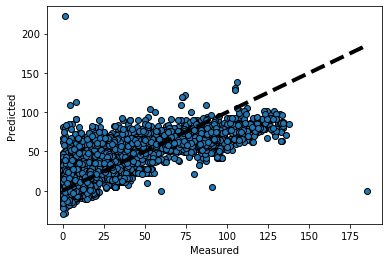

In [98]:
model = Ridge(alpha=0.05)
model.fit(X_train,y_train)

predictions = model.predict(X_test)
accuracy = model.score(X_test,y_test)

print ("accuracy is: ",accuracy*100,'%')


fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
#Lasso Regression

accuracy is:  63.11639634807717 %


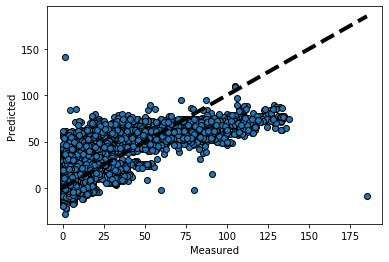

In [100]:
model = Lasso(alpha=0.1)
model.fit(X_train,y_train)

predictions = model.predict(X_test)
accuracy = model.score(X_test,y_test)

print ("accuracy is: ",accuracy*100,'%')


fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
#Decision Tree

Mean Absolute Error: 0.06996589901947384
Root Mean Squared Error: 0.12514458821804794
      Actual  Predicted
0  -0.229406  -0.122322
1   0.427185   0.400332
2   0.181046   0.102586
3   0.008050  -0.014870
4  -0.116108  -0.107361
5   0.314650   0.388237
6   0.402650   0.418521
7   0.255269   0.282043
8   0.159559   0.159559
9  -0.183330  -0.062588
10 -0.205154  -0.206974
11  0.177568   0.178266
12  0.148223   0.074380
13  0.144348  -0.037139
14 -0.278042  -0.379139
15  0.194585  -0.097023
16  0.040931  -0.122322
17  0.388237   0.328078
18  0.377021   0.380224
19  0.423546   0.423656

accuracy is:  69.81008653704338 %


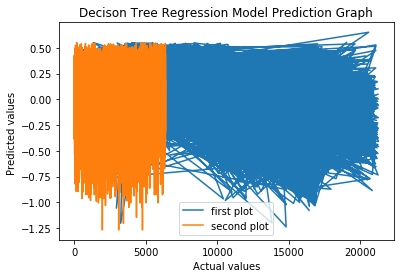

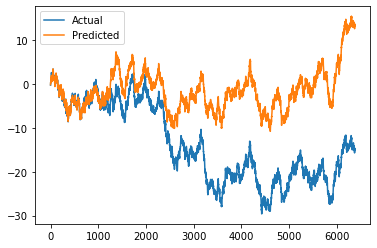

In [116]:
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as metrics

regressor = DecisionTreeRegressor(random_state=0)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

MAE_DT=metrics.mean_absolute_error(y_test, y_pred) 
SQRT_DT=np.sqrt(metrics.mean_squared_error(y_test, y_pred))


print('Mean Absolute Error:', MAE_DT)  
print('Root Mean Squared Error:',SQRT_DT )


# visulizing distance

b3 = y_test.ravel()
c3 = y_pred.ravel()  

df = pd.DataFrame({'Actual': b3, 'Predicted': c3})   
print(df.head(20))

# Plotting Graph

plt.plot(y_test, label='first plot')
plt.plot(y_pred, label='second plot')
plt.title("Decison Tree Regression Model Prediction Graph")
plt.xlabel("Actual values")
plt.ylabel("Predicted values ")
plt.legend()

# Graph 

df = df.cumsum();
df.plot();




accuracy = model.score(X_test,y_test)

print ("\naccuracy is: ",accuracy*100,'%')

In [ ]:
#K-Means CLustering

In [151]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples, silhouette_score

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

In [153]:
retail_df = pd.read_csv("Online Retail.csv", sep = ',',encoding = "ISO-8859-1", header= 0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [154]:
retail_uk = retail_df[retail_df['Country']=='United Kingdom']
#check the shape
retail_uk.shape

(495478, 8)

In [155]:
#remove canceled orders
retail_uk = retail_uk[retail_uk['Quantity']>0]
retail_uk.shape

(486286, 8)

In [156]:
#remove rows where customerID are NA
retail_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_uk.shape

(354345, 8)

In [157]:
#restrict the data to one full year because it's better to use a metric per Months or Years in RFM
retail_uk = retail_uk[retail_uk['InvoiceDate']>= "2010-12-09"]
retail_uk.shape

(110651, 8)

In [158]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", retail_uk['InvoiceNo'].nunique())
print("Number of products bought: ",retail_uk['StockCode'].nunique())
print("Number of customers:", retail_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(retail_uk['CustomerID'].isnull().sum() * 100 / len(retail_df),2),"%" )

Summary..
Number of transactions:  5062
Number of products bought:  3297
Number of customers: 2306
Percentage of customers NA:  0.0 %


In [ ]:
#RFM ANALYSIS
#RECENCY

In [159]:
#last date available in our dataset
retail_uk['InvoiceDate'].max()

'31-10-2011 17:13'

In [171]:
#create a new column called date which contains the date of invoice only
retail_uk['date'] = pd.to_datetime(retail_uk['InvoiceDate']).dt.date

In [172]:
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
39641,539658,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,21-12-2010 09:34,2.95,17213.0,United Kingdom,2010-12-21
39642,539658,84949,SILVER HANGING T-LIGHT HOLDER,6,21-12-2010 09:34,1.65,17213.0,United Kingdom,2010-12-21
39643,539658,21756,BATH BUILDING BLOCK WORD,3,21-12-2010 09:34,5.95,17213.0,United Kingdom,2010-12-21
39644,539658,22977,DOLLY GIRL CHILDRENS EGG CUP,12,21-12-2010 09:34,1.25,17213.0,United Kingdom,2010-12-21
39645,539658,84032B,CHARLIE + LOLA RED HOT WATER BOTTLE,6,21-12-2010 09:34,2.95,17213.0,United Kingdom,2010-12-21


In [173]:
#group by customers and check last date of purshace
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12747.0,2011-08-22
1,12748.0,2011-11-29
2,12820.0,2011-10-26
3,12822.0,2011-09-30
4,12823.0,2011-09-26


In [174]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [175]:
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,12747.0,2011-08-22,109
1,12748.0,2011-11-29,10
2,12820.0,2011-10-26,44
3,12822.0,2011-09-30,70
4,12823.0,2011-09-26,74


In [176]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

In [ ]:
#Frequency

In [177]:
# drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12747.0,3
1,12748.0,74
2,12820.0,2
3,12822.0,1
4,12823.0,3


In [ ]:
#Monetary

In [178]:
#create column total cost
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']

In [179]:
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12747.0,135.15
1,12748.0,1006.35
2,12820.0,30.00
3,12822.0,10.40
4,12823.0,1224.00


In [180]:
#RFM Table
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12747.0,109,3
1,12748.0,10,74
2,12820.0,44,2
3,12822.0,70,1
4,12823.0,74,3


In [181]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12747.0,109,3,135.15
12748.0,10,74,1006.35
12820.0,44,2,30.00
12822.0,70,1,10.40
12823.0,74,3,1224.00


In [ ]:
#Customer segments with RFM Model
#Applying 80-20 rule

In [182]:
#get the 80% of the revenue
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  200833.44


In [183]:
customers_rank = rfm_df
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12747.0,109,3,135.15,307.0
12748.0,10,74,1006.35,35.0
12820.0,44,2,30.00,1092.0
12822.0,70,1,10.40,1874.5
12823.0,74,3,1224.00,24.0


In [184]:
#Top Customers
customers_rank.sort_values('Rank',ascending=True)

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
17949.0,17,21,16925.97,1.0
17450.0,10,19,10806.15,2.0
18102.0,11,14,10293.64,3.0
14607.0,15,13,4754.18,4.0
15769.0,40,9,4180.40,5.0
...,...,...,...,...
17472.0,288,1,0.42,2301.5
13573.0,253,1,0.42,2301.5
15334.0,163,1,0.29,2304.0


In [185]:
#get top 20% of the customers
top_20_cutoff = 3863 *20 /100
top_20_cutoff

772.6

In [186]:
#sum the monetary values over the customer with rank <=773
revenueByTop20 = customers_rank[customers_rank['Rank'] <= 772]['Monetary'].sum()
revenueByTop20

222004.96

In [187]:
#Applying RFM score formula
#RFM Quartiles
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary,Rank
0.25,17.0,1.0,14.85,578.0
0.50,73.0,1.0,26.48,1153.5
0.75,165.0,2.0,69.60,1725.5


In [188]:
quantiles.to_dict()

{'Recency': {0.25: 17.0, 0.5: 73.0, 0.75: 165.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 14.850000000000001, 0.5: 26.48, 0.75: 69.6},
 'Rank': {0.25: 578.0, 0.5: 1153.5, 0.75: 1725.5}}

In [190]:
#Creation of RFM segmentation table
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [191]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [193]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12747.0,109,3,135.15,307.0,2,4,4,244
12748.0,10,74,1006.35,35.0,4,4,4,444
12820.0,44,2,30.00,1092.0,3,3,3,333
12822.0,70,1,10.40,1874.5,3,1,1,311
12823.0,74,3,1224.00,24.0,2,4,4,244


In [194]:
#Applying K-means clustering on RFM variables
#Preprocess Data
rfm_data = rfm_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore'],axis=1)
rfm_data.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12747.0,109,3,135.15,307.0
12748.0,10,74,1006.35,35.0
12820.0,44,2,30.00,1092.0
12822.0,70,1,10.40,1874.5
12823.0,74,3,1224.00,24.0


In [195]:
rfm_data.corr()

,Recency,Frequency,Monetary,Rank
Recency,1.000000,-0.248157,-0.081285,0.224669
Frequency,-0.248157,1.000000,0.405825,-0.417597
Monetary,-0.081285,0.405825,1.000000,-0.266562
Rank,0.224669,-0.417597,-0.266562,1.000000


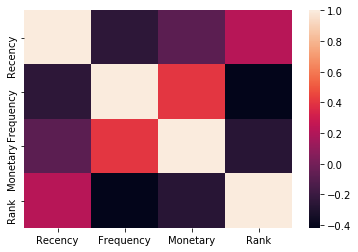

In [196]:
sns.heatmap(rfm_data.corr())

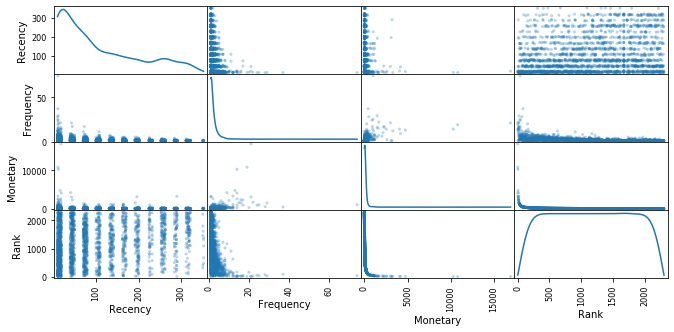

In [197]:
#Produce a scatter matrix for each pair of features in the data
scatter_matrix(rfm_data, alpha = 0.3, figsize = (11,5), diagonal = 'kde');

In [198]:
#Data Normalization
#log transformation
rfm_r_log = np.log(rfm_data['Recency']+0.1) #can't take log(0) and so add a small number
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)

In [199]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})
log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12747.0,4.907125,4.692265,1.098612
12748.0,6.914185,2.312535,4.304065
12820.0,3.404525,3.786460,0.693147
12822.0,2.351375,4.249923,0.000000
12823.0,7.109961,4.305416,1.098612


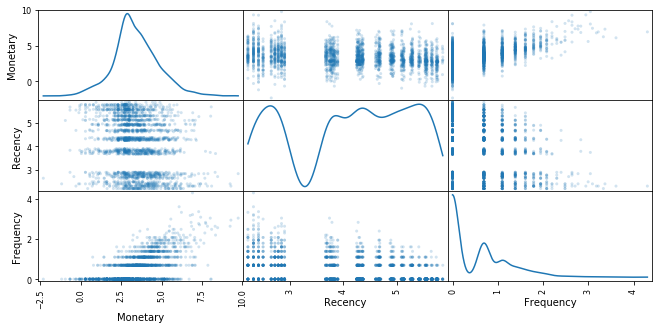

In [200]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(log_data, alpha = 0.2, figsize = (11,5), diagonal = 'kde');

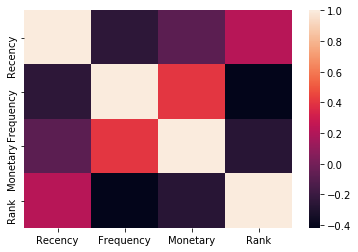

In [201]:
sns.heatmap(rfm_data.corr())

In [203]:
log_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,-0.209085,0.613350
Recency,-0.209085,1.000000,-0.397796
Frequency,0.613350,-0.397796,1.000000


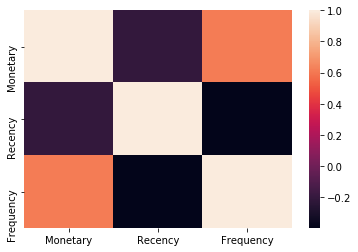

In [202]:
sns.heatmap(log_data.corr())

In [205]:
#K-means Implementation
matrix = log_data.to_numpy() 
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.36329422319016974
For n_clusters = 3 The average silhouette_score is : 0.3431422812375401
For n_clusters = 4 The average silhouette_score is : 0.3199838936581894
For n_clusters = 5 The average silhouette_score is : 0.33865219547847847
For n_clusters = 6 The average silhouette_score is : 0.3238532875121851
For n_clusters = 7 The average silhouette_score is : 0.31843939450225933
For n_clusters = 8 The average silhouette_score is : 0.33697717690312334
For n_clusters = 9 The average silhouette_score is : 0.34141190961759244


In [206]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.363


,1,0
NumberCustomers,1366,940


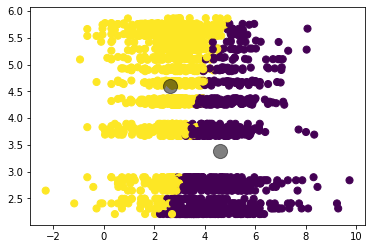

In [211]:
#Visualise clusters
#create a scatter plot
plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers, s=50, cmap='viridis')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

# What's the number of customers in each cluster?
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T

In [ ]:
#Hierarchical Agglomerative Clustering

In [213]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [216]:
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(2306, 8)

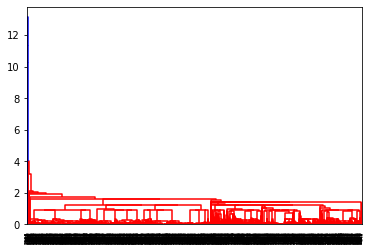

In [217]:
# Single linkage: 

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

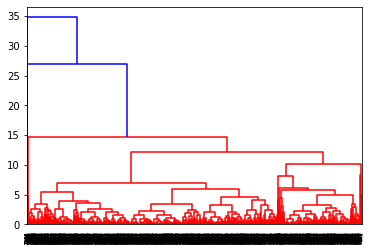

In [218]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

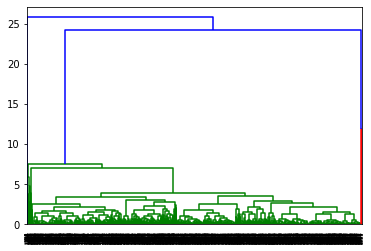

In [219]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [220]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [221]:
# Assign cluster labels

rfm_df['Cluster_Labels'] = cluster_labels
rfm_df.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore,Cluster_Labels
CustomerID,,,,,,,,,
12747.0,109,3,135.15,307.0,2,4,4,244,0
12748.0,10,74,1006.35,35.0,4,4,4,444,1
12820.0,44,2,30.00,1092.0,3,3,3,333,0
12822.0,70,1,10.40,1874.5,3,1,1,311,0
12823.0,74,3,1224.00,24.0,2,4,4,244,0


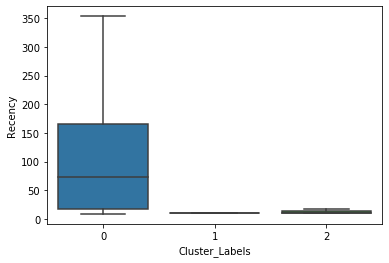

In [224]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm_df)

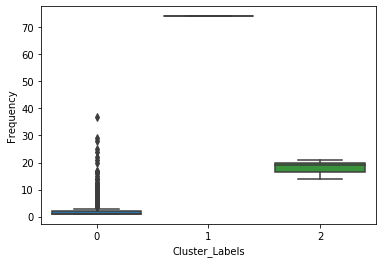

In [225]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm_df)

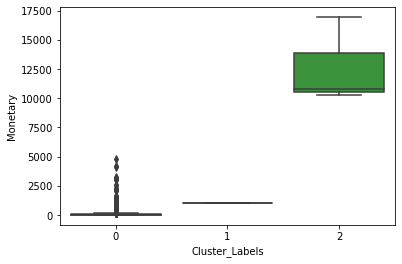

In [226]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Monetary', data=rfm_df)

In [ ]:
#Apriori Algorithm

In [227]:
import seaborn as sns
%matplotlib inline

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [228]:
retail_df = pd.read_csv("Online Retail.csv", sep = ',',encoding = "ISO-8859-1", header= 0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [229]:
#remove additional spaces
retail_df['Description'] = retail_df['Description'].str.strip()
#remove NA values
retail_df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
#remove cancelled orders
retail_df['InvoiceNo'] = retail_df['InvoiceNo'].astype('str')
retail_df = retail_df[~retail_df['InvoiceNo'].str.contains('C')]

In [230]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

def create_basket(country_filter):
    basket = (retail_df[retail_df['Country'] == country_filter]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
    return basket

In [231]:
country_filter = "France"
basket_french = create_basket("France")
basket_sets = basket_french.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

In [232]:
frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)

In [233]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.096939,0.102041,0.073980,0.763158,7.478947,0.064088,3.791383
1,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102041,0.096939,0.073980,0.725000,7.478947,0.064088,3.283859
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.096939,0.094388,0.079082,0.815789,8.642959,0.069932,4.916181
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.094388,0.096939,0.079082,0.837838,8.642959,0.069932,5.568878
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102041,0.094388,0.073980,0.725000,7.681081,0.064348,3.293135


In [ ]:
#FP GROWTH

In [235]:
from mlxtend.frequent_patterns import fpgrowth

In [238]:
frequent_itemsets = fpgrowth(basket_sets, min_support=0.05, use_colnames=True)

In [239]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(RED TOADSTOOL LED NIGHT LIGHT),(RABBIT NIGHT LIGHT),0.181122,0.188776,0.053571,0.295775,1.566806,0.019380,1.151939
1,(RABBIT NIGHT LIGHT),(RED TOADSTOOL LED NIGHT LIGHT),0.188776,0.181122,0.053571,0.283784,1.566806,0.019380,1.143338
2,(PLASTERS IN TIN CIRCUS PARADE),(ROUND SNACK BOXES SET OF4 WOODLAND),0.168367,0.158163,0.053571,0.318182,2.011730,0.026942,1.234694
3,(ROUND SNACK BOXES SET OF4 WOODLAND),(PLASTERS IN TIN CIRCUS PARADE),0.158163,0.168367,0.053571,0.338710,2.011730,0.026942,1.257591
4,(SPACEBOY LUNCH BOX),(LUNCH BAG RED RETROSPOT),0.125000,0.153061,0.053571,0.428571,2.800000,0.034439,1.482143
